<a href="https://colab.research.google.com/github/rachanashinde15/DemoGIt/blob/master/Layer3Resnetciphar100.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
#Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from tensorflow.keras import datasets,models,layers


In [32]:
# Adding TF Cifar10 Data ..
from keras.datasets import cifar100
(X_train, Y_train), (X_test, Y_test) = cifar100.load_data()

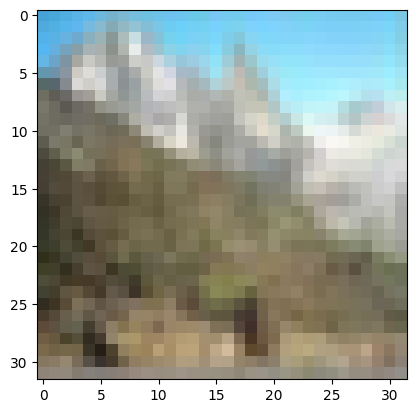

In [33]:
# Drawing sample . 
plt.imshow(X_train[42])

In [34]:
# Normalize the data.
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255.0
X_test /= 255.0

In [35]:
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.2,shuffle = True)

In [36]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
encoder.fit(Y_train)
Y_train = encoder.transform(Y_train).toarray()
Y_test = encoder.transform(Y_test).toarray()
Y_val =  encoder.transform(Y_val).toarray()

In [37]:
from keras.preprocessing.image import ImageDataGenerator
aug = ImageDataGenerator(horizontal_flip=True, width_shift_range=0.05,
                             height_shift_range=0.05)
aug.fit(X_train)

In [44]:
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Conv2D,  MaxPool2D, Flatten, GlobalAveragePooling2D,  BatchNormalization, Layer, Add
from keras.models import Sequential
from keras.models import Model
import tensorflow as tf


class ResnetBlock(Model):
    """
    A standard resnet block.
    """

    def __init__(self, channels: int, down_sample=False):
        """
        channels: same as number of convolution kernels
        """
        super().__init__()

        self.__channels = channels
        self.__down_sample = down_sample
        self.__strides = [2, 1] if down_sample else [1, 1]

        KERNEL_SIZE = (3, 3)
        # use He initialization, instead of Xavier (a.k.a 'glorot_uniform' in Keras), as suggested in [2]
        INIT_SCHEME = "he_normal"

        self.conv_1 = Conv2D(self.__channels, strides=self.__strides[0],
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)
        self.bn_1 = BatchNormalization()
        self.conv_2 = Conv2D(self.__channels, strides=self.__strides[1],
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)
        self.bn_2 = BatchNormalization()
        self.merge = Add()

        if self.__down_sample:
            # perform down sampling using stride of 2, according to [1].
            self.res_conv = Conv2D(
                self.__channels, strides=2, kernel_size=(1, 1), kernel_initializer=INIT_SCHEME, padding="same")
            self.res_bn = BatchNormalization()

    def call(self, inputs):
        res = inputs

        x = self.conv_1(inputs)
        x = self.bn_1(x)
        x = tf.nn.relu(x)
        x = self.conv_2(x)
        x = self.bn_2(x)

        if self.__down_sample:
            res = self.res_conv(res)
            res = self.res_bn(res)

        # if not perform down sample, then add a shortcut directly
        x = self.merge([x, res])
        out = tf.nn.relu(x)
        return out


class ResNet18(Model):
    def __init__(self, num_classes, **kwargs):
        super().__init__(**kwargs)
        self.conv_1 = Conv2D(64, (7, 7), strides=2, padding="same", kernel_initializer="he_normal")
        self.init_bn = BatchNormalization()
        self.pool_2 = MaxPool2D(pool_size=(2, 2), strides=2, padding="same")
        self.res_1 = ResnetBlock(64)
        self.avg_pool = GlobalAveragePooling2D()
        self.flat = Flatten()
        self.fc = Dense(num_classes, activation="softmax")

    def call(self, inputs):
        out = self.conv_1(inputs)
        out = self.init_bn(out)
        out = tf.nn.relu(out)
        out = self.pool_2(out)

        out = self.res_1(out)

        out = self.avg_pool(out)
        out = self.flat(out)
        out = self.fc(out)
        return out


In [45]:
model = ResNet18(100)
model.build(input_shape = (None,32,32,3))
#use categorical_crossentropy since the label is one-hot encoded
from keras.optimizers import SGD
# opt = SGD(learning_rate=0.1,momentum=0.9,decay = 1e-04) #parameters suggested by He [1]
model.compile(optimizer = "adam",loss='categorical_crossentropy', metrics=["accuracy"]) 
model.summary()

Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "res_net18_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_19 (Conv2D)          multiple                  9472      
                                                                 
 batch_normalization_18 (Bat  multiple                 256       
 chNormalization)                                                
                                                                 
 max_pooling2d_3 (MaxPooling  multiple                 0         
 2D)                                                             
                                                                 
 resnet_block_6 (ResnetBlock  multiple                 74368     
 )                                                               
                                                  

In [46]:
from keras.callbacks import EarlyStopping

es = EarlyStopping(patience= 8, restore_best_weights=True, monitor="val_acc")
#I did not use cross validation, so the validate performance is not accurate.
STEPS = len(X_train) / 256
history = model.fit(aug.flow(X_train,Y_train,batch_size = 256), steps_per_epoch=STEPS, batch_size = 256, epochs=50, validation_data=(X_train, Y_train),callbacks=[es])

Epoch 1/50
157/156 [==============================] - ETA: 0s - loss: 4.1437 - accuracy: 0.0840

156/156 [==============================] - 24s 136ms/step - loss: 4.1437 - accuracy: 0.0840 - val_loss: 4.2270 - val_accuracy: 0.0496
Epoch 2/50
157/156 [==============================] - ETA: 0s - loss: 3.6576 - accuracy: 0.1512

156/156 [==============================] - 19s 122ms/step - loss: 3.6576 - accuracy: 0.1512 - val_loss: 3.8262 - val_accuracy: 0.1015
Epoch 3/50
157/156 [==============================] - ETA: 0s - loss: 3.3859 - accuracy: 0.1968

156/156 [==============================] - 19s 125ms/step - loss: 3.3859 - accuracy: 0.1968 - val_loss: 3.3824 - val_accuracy: 0.1884
Epoch 4/50
157/156 [==============================] - ETA: 0s - loss: 3.1959 - accuracy: 0.2271

156/156 [==============================] - 21s 135ms/step - loss: 3.1959 - accuracy: 0.2271 - val_loss: 3.2121 - val_accuracy: 0.2170
Epoch 5/50
157/156 [==============================] - ETA: 0s - loss: 3.0474 - accuracy: 0.2540

156/156 [==============================] - 19s 122ms/step - loss: 3.0474 - accuracy: 0.2540 - val_loss: 3.5654 - val_accuracy: 0.1574
Epoch 6/50
157/156 [==============================] - ETA: 0s - loss: 2.9549 - accuracy: 0.2670

156/156 [==============================] - 19s 122ms/step - loss: 2.9549 - accuracy: 0.2670 - val_loss: 3.1172 - val_accuracy: 0.2308
Epoch 7/50
157/156 [==============================] - ETA: 0s - loss: 2.8566 - accuracy: 0.2847

156/156 [==============================] - 20s 127ms/step - loss: 2.8566 - accuracy: 0.2847 - val_loss: 3.0188 - val_accuracy: 0.2495
Epoch 8/50
157/156 [==============================] - ETA: 0s - loss: 2.7834 - accuracy: 0.3002

156/156 [==============================] - 19s 122ms/step - loss: 2.7834 - accuracy: 0.3002 - val_loss: 2.9444 - val_accuracy: 0.2611
Epoch 9/50
157/156 [==============================] - ETA: 0s - loss: 2.7329 - accuracy: 0.3114

156/156 [==============================] - 19s 124ms/step - loss: 2.7329 - accuracy: 0.3114 - val_loss: 3.3903 - val_accuracy: 0.2074
Epoch 10/50
157/156 [==============================] - ETA: 0s - loss: 2.6650 - accuracy: 0.3236

156/156 [==============================] - 18s 118ms/step - loss: 2.6650 - accuracy: 0.3236 - val_loss: 3.2412 - val_accuracy: 0.2235
Epoch 11/50
157/156 [==============================] - ETA: 0s - loss: 2.6294 - accuracy: 0.3283

156/156 [==============================] - 19s 122ms/step - loss: 2.6294 - accuracy: 0.3283 - val_loss: 2.9358 - val_accuracy: 0.2720
Epoch 12/50
157/156 [==============================] - ETA: 0s - loss: 2.5754 - accuracy: 0.3442

156/156 [==============================] - 19s 122ms/step - loss: 2.5754 - accuracy: 0.3442 - val_loss: 2.7364 - val_accuracy: 0.3031
Epoch 13/50
157/156 [==============================] - ETA: 0s - loss: 2.5421 - accuracy: 0.3483

156/156 [==============================] - 18s 118ms/step - loss: 2.5421 - accuracy: 0.3483 - val_loss: 2.6969 - val_accuracy: 0.3143
Epoch 14/50
157/156 [==============================] - ETA: 0s - loss: 2.5018 - accuracy: 0.3554

156/156 [==============================] - 20s 126ms/step - loss: 2.5018 - accuracy: 0.3554 - val_loss: 2.8601 - val_accuracy: 0.2882
Epoch 15/50
157/156 [==============================] - ETA: 0s - loss: 2.4640 - accuracy: 0.3662

156/156 [==============================] - 19s 119ms/step - loss: 2.4640 - accuracy: 0.3662 - val_loss: 2.8642 - val_accuracy: 0.2840
Epoch 16/50
157/156 [==============================] - ETA: 0s - loss: 2.4361 - accuracy: 0.3721

156/156 [==============================] - 20s 128ms/step - loss: 2.4361 - accuracy: 0.3721 - val_loss: 2.7225 - val_accuracy: 0.3076
Epoch 17/50
157/156 [==============================] - ETA: 0s - loss: 2.3972 - accuracy: 0.3796

156/156 [==============================] - 19s 119ms/step - loss: 2.3972 - accuracy: 0.3796 - val_loss: 2.8266 - val_accuracy: 0.2964
Epoch 18/50
157/156 [==============================] - ETA: 0s - loss: 2.3767 - accuracy: 0.3837

156/156 [==============================] - 20s 125ms/step - loss: 2.3767 - accuracy: 0.3837 - val_loss: 2.7241 - val_accuracy: 0.3083
Epoch 19/50
157/156 [==============================] - ETA: 0s - loss: 2.3475 - accuracy: 0.3872

156/156 [==============================] - 20s 128ms/step - loss: 2.3475 - accuracy: 0.3872 - val_loss: 3.3328 - val_accuracy: 0.2483
Epoch 20/50
157/156 [==============================] - ETA: 0s - loss: 2.3297 - accuracy: 0.3920

156/156 [==============================] - 19s 123ms/step - loss: 2.3297 - accuracy: 0.3920 - val_loss: 2.6532 - val_accuracy: 0.3261
Epoch 21/50
157/156 [==============================] - ETA: 0s - loss: 2.2982 - accuracy: 0.3998

156/156 [==============================] - 19s 124ms/step - loss: 2.2982 - accuracy: 0.3998 - val_loss: 2.5577 - val_accuracy: 0.3508
Epoch 22/50
157/156 [==============================] - ETA: 0s - loss: 2.2746 - accuracy: 0.4059

156/156 [==============================] - 19s 121ms/step - loss: 2.2746 - accuracy: 0.4059 - val_loss: 2.6225 - val_accuracy: 0.3332
Epoch 23/50
157/156 [==============================] - ETA: 0s - loss: 2.2590 - accuracy: 0.4079

156/156 [==============================] - 19s 121ms/step - loss: 2.2590 - accuracy: 0.4079 - val_loss: 2.6600 - val_accuracy: 0.3234
Epoch 24/50
157/156 [==============================] - ETA: 0s - loss: 2.2426 - accuracy: 0.4117

156/156 [==============================] - 20s 127ms/step - loss: 2.2426 - accuracy: 0.4117 - val_loss: 2.5729 - val_accuracy: 0.3497
Epoch 25/50
157/156 [==============================] - ETA: 0s - loss: 2.2222 - accuracy: 0.4164

156/156 [==============================] - 19s 122ms/step - loss: 2.2222 - accuracy: 0.4164 - val_loss: 2.5446 - val_accuracy: 0.3459
Epoch 26/50
157/156 [==============================] - ETA: 0s - loss: 2.2111 - accuracy: 0.4178

156/156 [==============================] - 19s 119ms/step - loss: 2.2111 - accuracy: 0.4178 - val_loss: 2.7528 - val_accuracy: 0.3161
Epoch 27/50
157/156 [==============================] - ETA: 0s - loss: 2.1847 - accuracy: 0.4227

156/156 [==============================] - 19s 123ms/step - loss: 2.1847 - accuracy: 0.4227 - val_loss: 2.5536 - val_accuracy: 0.3449
Epoch 28/50
157/156 [==============================] - ETA: 0s - loss: 2.1716 - accuracy: 0.4264

156/156 [==============================] - 18s 118ms/step - loss: 2.1716 - accuracy: 0.4264 - val_loss: 2.6268 - val_accuracy: 0.3443
Epoch 29/50
157/156 [==============================] - ETA: 0s - loss: 2.1574 - accuracy: 0.4313

156/156 [==============================] - 19s 123ms/step - loss: 2.1574 - accuracy: 0.4313 - val_loss: 2.6607 - val_accuracy: 0.3342
Epoch 30/50
157/156 [==============================] - ETA: 0s - loss: 2.1387 - accuracy: 0.4363

156/156 [==============================] - 19s 120ms/step - loss: 2.1387 - accuracy: 0.4363 - val_loss: 2.3969 - val_accuracy: 0.3809
Epoch 31/50
157/156 [==============================] - ETA: 0s - loss: 2.1245 - accuracy: 0.4360

156/156 [==============================] - 18s 118ms/step - loss: 2.1245 - accuracy: 0.4360 - val_loss: 2.2567 - val_accuracy: 0.4105
Epoch 32/50
157/156 [==============================] - ETA: 0s - loss: 2.1100 - accuracy: 0.4415

156/156 [==============================] - 20s 125ms/step - loss: 2.1100 - accuracy: 0.4415 - val_loss: 2.3324 - val_accuracy: 0.3888
Epoch 33/50
157/156 [==============================] - ETA: 0s - loss: 2.0884 - accuracy: 0.4455

156/156 [==============================] - 18s 118ms/step - loss: 2.0884 - accuracy: 0.4455 - val_loss: 2.6368 - val_accuracy: 0.3364
Epoch 34/50
157/156 [==============================] - ETA: 0s - loss: 2.0765 - accuracy: 0.4528

156/156 [==============================] - 19s 124ms/step - loss: 2.0765 - accuracy: 0.4528 - val_loss: 2.3554 - val_accuracy: 0.3842
Epoch 35/50
157/156 [==============================] - ETA: 0s - loss: 2.0746 - accuracy: 0.4503

156/156 [==============================] - 19s 123ms/step - loss: 2.0746 - accuracy: 0.4503 - val_loss: 2.4439 - val_accuracy: 0.3762
Epoch 36/50
157/156 [==============================] - ETA: 0s - loss: 2.0581 - accuracy: 0.4534

156/156 [==============================] - 19s 122ms/step - loss: 2.0581 - accuracy: 0.4534 - val_loss: 2.5030 - val_accuracy: 0.3670
Epoch 37/50
157/156 [==============================] - ETA: 0s - loss: 2.0459 - accuracy: 0.4543

156/156 [==============================] - 19s 123ms/step - loss: 2.0459 - accuracy: 0.4543 - val_loss: 2.5506 - val_accuracy: 0.3644
Epoch 38/50
157/156 [==============================] - ETA: 0s - loss: 2.0454 - accuracy: 0.4559

156/156 [==============================] - 18s 118ms/step - loss: 2.0454 - accuracy: 0.4559 - val_loss: 2.4037 - val_accuracy: 0.3877
Epoch 39/50
157/156 [==============================] - ETA: 0s - loss: 2.0272 - accuracy: 0.4593

156/156 [==============================] - 19s 123ms/step - loss: 2.0272 - accuracy: 0.4593 - val_loss: 2.2834 - val_accuracy: 0.4105
Epoch 40/50
157/156 [==============================] - ETA: 0s - loss: 2.0206 - accuracy: 0.4602

156/156 [==============================] - 18s 118ms/step - loss: 2.0206 - accuracy: 0.4602 - val_loss: 2.1860 - val_accuracy: 0.4180
Epoch 41/50
157/156 [==============================] - ETA: 0s - loss: 2.0018 - accuracy: 0.4663

156/156 [==============================] - 19s 123ms/step - loss: 2.0018 - accuracy: 0.4663 - val_loss: 2.4020 - val_accuracy: 0.3779
Epoch 42/50
157/156 [==============================] - ETA: 0s - loss: 1.9985 - accuracy: 0.4656

156/156 [==============================] - 19s 121ms/step - loss: 1.9985 - accuracy: 0.4656 - val_loss: 2.2484 - val_accuracy: 0.4099
Epoch 43/50
157/156 [==============================] - ETA: 0s - loss: 1.9860 - accuracy: 0.4705

156/156 [==============================] - 19s 121ms/step - loss: 1.9860 - accuracy: 0.4705 - val_loss: 2.5407 - val_accuracy: 0.3523
Epoch 44/50
157/156 [==============================] - ETA: 0s - loss: 1.9735 - accuracy: 0.4712

156/156 [==============================] - 19s 123ms/step - loss: 1.9735 - accuracy: 0.4712 - val_loss: 2.2578 - val_accuracy: 0.4078
Epoch 45/50
157/156 [==============================] - ETA: 0s - loss: 1.9668 - accuracy: 0.4746

156/156 [==============================] - 19s 121ms/step - loss: 1.9668 - accuracy: 0.4746 - val_loss: 2.2846 - val_accuracy: 0.4020
Epoch 46/50
157/156 [==============================] - ETA: 0s - loss: 1.9646 - accuracy: 0.4735

156/156 [==============================] - 19s 120ms/step - loss: 1.9646 - accuracy: 0.4735 - val_loss: 2.1245 - val_accuracy: 0.4384
Epoch 47/50
157/156 [==============================] - ETA: 0s - loss: 1.9449 - accuracy: 0.4793

156/156 [==============================] - 19s 120ms/step - loss: 1.9449 - accuracy: 0.4793 - val_loss: 2.5368 - val_accuracy: 0.3680
Epoch 48/50
157/156 [==============================] - ETA: 0s - loss: 1.9414 - accuracy: 0.4782

156/156 [==============================] - 18s 116ms/step - loss: 1.9414 - accuracy: 0.4782 - val_loss: 2.5667 - val_accuracy: 0.3649
Epoch 49/50
157/156 [==============================] - ETA: 0s - loss: 1.9317 - accuracy: 0.4816

156/156 [==============================] - 19s 120ms/step - loss: 1.9317 - accuracy: 0.4816 - val_loss: 2.3109 - val_accuracy: 0.4009
Epoch 50/50
157/156 [==============================] - ETA: 0s - loss: 1.9216 - accuracy: 0.4834

156/156 [==============================] - 19s 120ms/step - loss: 1.9216 - accuracy: 0.4834 - val_loss: 2.2851 - val_accuracy: 0.4015


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


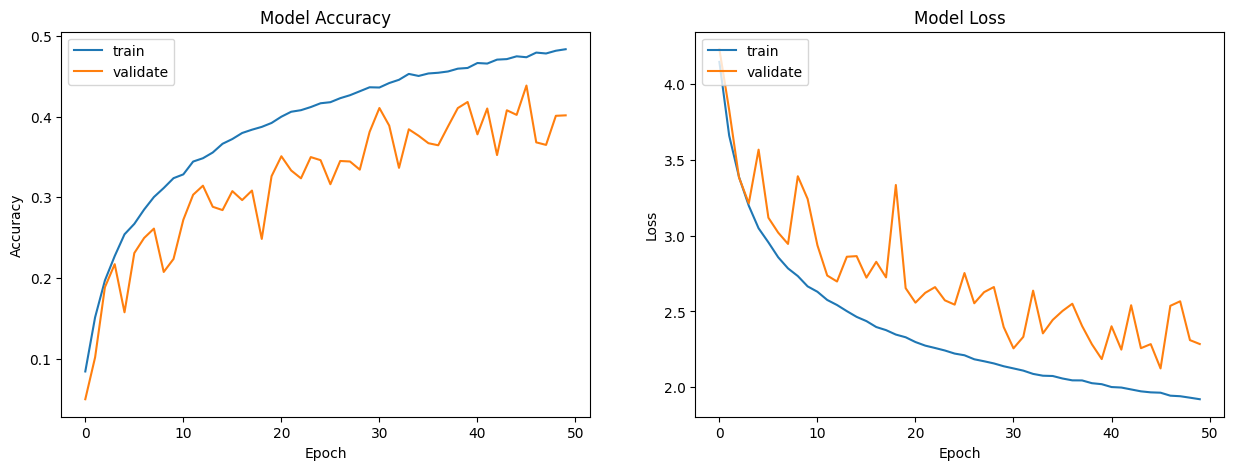

In [47]:
def plotmodelhistory(history): 
    fig, axs = plt.subplots(1,2,figsize=(15,5)) 
    # summarize history for accuracy
    axs[0].plot(history.history['accuracy']) 
    axs[0].plot(history.history['val_accuracy']) 
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy') 
    axs[0].set_xlabel('Epoch')
    
    axs[0].legend(['train', 'validate'], loc='upper left')
    # summarize history for loss
    axs[1].plot(history.history['loss']) 
    axs[1].plot(history.history['val_loss']) 
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss') 
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['train', 'validate'], loc='upper left')
    plt.show()

# list all data in history
print(history.history.keys())
plotmodelhistory(history)

In [48]:

ModelLoss, ModelAccuracy = model.evaluate(X_train, Y_train)

print('Model Loss is {}'.format(ModelLoss))
print('Model Accuracy is {}'.format(ModelAccuracy))

1250/1250 [==============================] - 4s 3ms/step - loss: 2.2851 - accuracy: 0.4015
Model Loss is 2.2851412296295166
Model Accuracy is 0.4014750123023987
